# Imports

In [1]:
import bs4
from typing import List, TypedDict

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Import Chroma vector store
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
# Import the base Embeddings class from LangChain
from langchain.embeddings.base import Embeddings


from langchain.chat_models import init_chat_model

from langchain_chroma import Chroma


USER_AGENT environment variable not set, consider setting it to identify your requests.


# Load Local GRC Files

In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders import FileSystemBlobLoader
from langchain_community.document_loaders.parsers import PyPDFParser
from pathlib import Path

data_path = Path("../../data/test-pdfs")

assert(data_path.is_dir())

loader = GenericLoader(
    blob_loader=FileSystemBlobLoader(
        path=data_path,
        glob="*.pdf",
    ),
    blob_parser=PyPDFParser(),
)

In [3]:
docs = loader.load()
# print(docs)
# print(docs[0].page_content)
# print([f'Document {i}: \n{doc.metadata}\n\n' for i,doc in enumerate(docs,0)])

In [4]:
# Split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Initialize the embeddings using nomic-embed-text

embeddings = OllamaEmbeddings(model="nomic-embed-text")

# Create the Chroma vector store from documents and embeddings
vector_store = Chroma(embedding_function=embeddings)

# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)

In [5]:
print(document_ids)

['2d8cca00-d713-492e-abff-4bd018baf188', '3ae936d5-7168-4ee8-953a-1f32a8b96d25', '7439b37b-7037-4c74-a029-9f769032aa1b', '706e3eff-9391-4169-bfa6-b8081a309d13', '38952204-3a39-41c1-a5f8-296bc45f95b9', 'f1b2778b-a064-4e34-9941-a8315dc5bd41', '6817649f-1577-43cb-910f-6da2fe2643e9', 'c088dbeb-5d55-47d9-baab-7eb32bb38c27', 'eed9af15-fa79-4038-84ff-95f162ef1cdd', '69ab187d-df4f-41b3-a221-813199c82135', 'f0e764e2-ef7b-4cb4-ab77-5e1497a7f28f', '16ed15e4-3b99-46e6-b4bd-cdc419dfc245', 'a8beb55c-86d9-4ba8-b557-92eef331f641', 'd7ccb51e-d630-4312-9d1f-d8b984d0c145', '846ed138-714d-45cf-85f3-bea0faf71325', 'b0154b8f-9e4d-4cd0-aa76-96991f851df1', '3e1af5dd-b7d4-4c0f-bd01-3ee1f8267a10', '54dc1ef7-cb8d-4918-b615-63c59659ea1a', 'c46055a1-ae3e-422e-b007-64ec90343633', 'f5c06197-6634-4e5b-9e3c-3d2821a567c1', 'e42fbbed-e71b-4f2d-a007-81e68502d91a', '090cec44-24df-4dda-bb80-31a0a42b4013', 'aefba02d-0a06-425b-831e-43a9c5806237', 'fe10ce65-a2bc-4e38-ad5a-7fb3e186c0b2', 'f5517f45-ae6a-48c9-9254-d3dd562171bb',

# Load LLM

In [6]:
llm = init_chat_model("llama3.2:3b-instruct-q8_0", model_provider="ollama")

# RAG

In [58]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

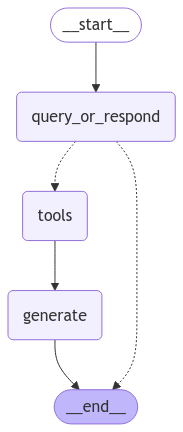

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.ai import AIMessage

show_tool_output = False

while True:
    input_message = input()
    if input_message == "exit":
        break

    for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
    ):
        if show_tool_output:
            step["messages"][-1].pretty_print()
        else:
            evnt = step["messages"][-1]
            if (type(evnt) == HumanMessage or type(evnt) == AIMessage) and evnt.content != '':
                evnt.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today? Do you have a specific question or topic you'd like to discuss? I'll do my best to help based on the context I've been trained on.
================================ Human Message =================================

Explain how RAG works
================================== Ai Message ==================================

Based on the retrieved context, it appears that RAG (Retrieval-Augmented Generation) is a technology that enhances the capabilities of Large Language Models (LLMs) by integrating parameterized knowledge from language models with extensive non-parameterized data from external knowledge bases.

Here's a high-level overview of how RAG works:

1. **Knowledge Retrieval**: RAG uses an external knowledge base to retrieve relevant information related to a given input question or t

KeyboardInterrupt: Interrupted by user